In [69]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [70]:
def add_data(hmap, data, ts):
    if ts not in hmap:
        hmap[ts] = data
    elif data != hmap[ts]:
        print(f"WHY {ts} is already in: {hmap}")

In [71]:
def create_df(filename, write=False):
    print(filename)
    with open(filename, 'r') as file:
        timestamps = []
        accel_x = []
        accel_y = []
        accel_z = []
        gyro_x = []
        gyro_y = []
        gyro_z = []

        for line in file:
            data_line = line.strip()
            if data_line and data_line[0].isdigit():
                # print(data_line)
                node_num, timestamp, ax, ay, az, gx, gy, gz, mx, my, mz = data_line.split(",")
                timestamps.append(int(timestamp))
                accel_x.append(float(ax))
                accel_y.append(float(ay))
                accel_z.append(float(az))
                gyro_x.append(float(gx))
                gyro_y.append(float(gy))
                gyro_z.append(float(gz))
        
        # accel_x = accel_x - np.mean(accel_x)
        # accel_y = accel_y - np.mean(accel_y)
        # accel_z = accel_z - np.mean(accel_z)
        # gyro_x = gyro_x - np.mean(gyro_x)
        # gyro_y = gyro_y - np.mean(gyro_y)
        # gyro_z = gyro_z - np.mean(gyro_z)

        df = pd.DataFrame({'timestamp': timestamps, 
                           'accel_x': accel_x, 
                           'accel_y': accel_y, 
                           'accel_z': accel_z, 
                           'gyro_x': gyro_x, 
                           'gyro_y': gyro_y, 
                           'gyro_z': gyro_z})
        cleaned_df = df.interpolate(method="linear", limit_direction="both")
        name = "../csvs2/" + filename.split("/")[-1].split(".")[0] + "_df.csv"
        if write:
            cleaned_df.to_csv(name, index=False)
        print(cleaned_df.head())
        return cleaned_df

In [72]:
def get_peaks_and_valleys(df, dist=100):
    peaks, _ = find_peaks(df["accel_z"], height=0, distance=dist)
    valleys, _ = find_peaks(-1 * df["accel_z"], height=0, distance=dist)

    peakvals = [(int(peak), float(df['accel_z'].iloc[peak])) for peak in peaks]
    valleyvals = [(int(valley), float(df['accel_z'].iloc[valley])) for valley in valleys]
    print(f"peakvals: {peakvals}")
    print(f"valleyvals: {valleyvals}")

    print(f"peaks: {peaks}, peakvals: {peakvals}")
    print(f"valleys: {valleys}, valleyvals: {valleyvals}")
    return peaks, valleys, peakvals, valleyvals

In [73]:
def plot_df(df, title, peaks=None, valleys=None):
    plt.figure(figsize=(10, 8))
    plt.plot(df["timestamp"], df["accel_x"], label="accel_x")
    plt.plot(df["timestamp"], df["accel_y"], label="accel_y")
    plt.plot(df["timestamp"], df["accel_z"], label="accel_z")
    plt.plot(df["timestamp"], df["gyro_x"], label="gyro_x")
    plt.plot(df["timestamp"], df["gyro_y"], label="gyro_y")
    plt.plot(df["timestamp"], df["gyro_z"], label="gyro_z")

    if peaks is not None and valleys is not None:
        plt.plot(df["timestamp"].iloc[peaks], df["accel_z"].iloc[peaks], "rx", label="peaks")
        plt.plot(df["timestamp"].iloc[valleys], df["accel_z"].iloc[valleys], "ro", label="valleys")

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Timestamp")
    plt.ylabel("IMU Data")
    plt.show()

In [74]:
def get_num_reps(df, peaks, valleys):
    valleyvals = [valley[1] for valley in valleys]
    valleyidxs = [valley[0] for valley in valleys]
    peakvals = [peak[1] for peak in peaks]
    peakidxs = [peak[0] for peak in peaks]

    valleymean = np.mean(valleyvals)
    print(valleymean)
    valley_outlier_indices = np.where(np.abs(valleyvals - valleymean) > 5)[0]
    print(f"valley_outlier_indices: {valley_outlier_indices}")

    peakmean = np.mean(peakvals)
    print(peakmean)
    peak_outlier_indices = np.where(np.abs(peakvals - peakmean) > 5)[0]
    print(f"peak_outlier_indices: {peak_outlier_indices}")

    valid_valley_idxs = [x for i, x in enumerate(valleyidxs) if i not in valley_outlier_indices]
    valid_peak_idxs = [x for i, x in enumerate(peakidxs) if i not in peak_outlier_indices]

    print(f"valid_valley_idxs: {valid_valley_idxs}")
    print(f"valid_peak_idxs: {valid_peak_idxs}")
    start = 0
    end = len(df)
    if valid_peak_idxs and valid_valley_idxs:
        start = max(valid_valley_idxs[0], valid_peak_idxs[0])
        end = max(valid_valley_idxs[-1], valid_peak_idxs[-1])
    print(f"start: {start}, end: {end}")


    num_valid_valleys = len(valleyidxs) - len(valley_outlier_indices)
    num_valid_peaks = len(peakidxs) - len(peak_outlier_indices)
    print(f"num_valid_peaks: {num_valid_peaks}, num_valid_valleys: {num_valid_valleys}")
    return start, end, num_valid_peaks, num_valid_valleys

    # Q1 = np.percentile(valleyvals, 90, method='midpoint')
    # print(Q1)
    # valley_outlier_indices = np.where(valleyvals > Q1)[0]
    # print(valley_outlier_indices)

    # Q1 = np.percentile(peakvals, 5, method='midpoint')
    # print(Q1)
    # peak_outlier_indices = np.where(peakvals < Q1)[0]
    # print(peak_outlier_indices)

../data2/row/row_andrew_set2_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     900185   -0.482    3.046   10.114   0.292  -0.148   0.023
1     900189   -0.482    3.046   10.114   0.292  -0.148   0.023
2     900192   -0.517    2.973   10.040   0.292  -0.148   0.023
3     900196   -0.517    2.973   10.040   0.301  -0.140   0.026
4     900276   -0.311    2.808    9.790   0.172  -0.140   0.020
peakvals: [(50, 15.392)]
valleyvals: []
peaks: [50], peakvals: [(50, 15.392)]
valleys: [], valleyvals: []


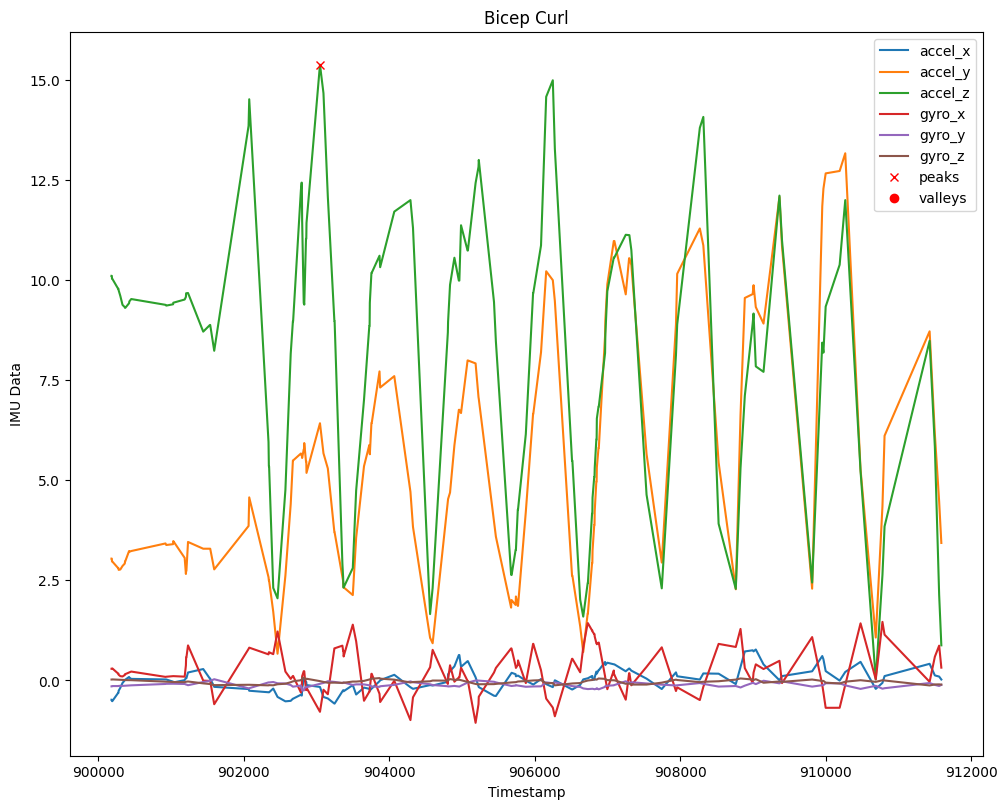

nan
valley_outlier_indices: []
15.392
peak_outlier_indices: []
valid_valley_idxs: []
valid_peak_idxs: [50]
start: 0, end: 160
num_valid_peaks: 1, num_valid_valleys: 0


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


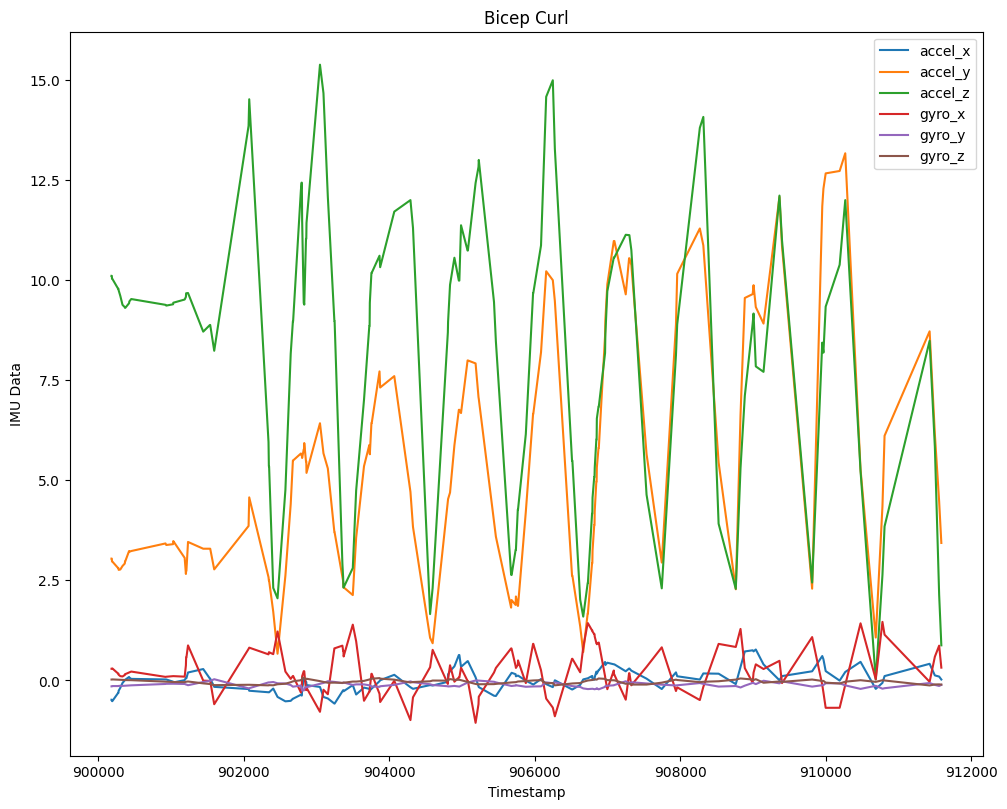

In [75]:
file = "../data2/row/row_andrew_set2_reps10_1.csv"
df = create_df(file)
peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
plot_df(df, "Bicep Curl", peaks, valleys)
start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)

df = df.iloc[start:end]
plot_df(df, "Bicep Curl")

In [76]:
def cropped_df(file):
    df = create_df(file)
    peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
    start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)
    # df = df.iloc[start:end]
    print(f"file: {file}, len(df): {len(df)}")
    return df

In [77]:
X_train = []
X_validation = []
X_test = []
max_len = 100

for f in training_files:
    print(f"train: {f}")
    df = cropped_df(f)
    max_len = max(max_len, len(df))
    X_train.append(df)

for f in validation_files:
    print(f"validation: {f}")
    df = cropped_df(f)
    max_len = max(max_len, len(df))
    X_validation.append(df)

for f in test_files:
    print(f"test: {f}")
    df = cropped_df(f)
    max_len = max(max_len, len(df))
    X_test.append(df)

y_train = np.array(train_labels)
y_validation = np.array(validation_labels)
y_test = np.array(test_labels)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

train: ../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007
peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1188, 12.439), (1366, 12.207), (1562, 12.272), (1752, 12.193), (1910, 11.174)]
valleyvals: [(142, -5.234), (330, -7.138), (527, -7.144), (710, -7.452), (904, -7.908), (1075, -8.465), (1264, -9.249), (1455, -8.989), (1631, -8.171), (1821, -8.157)]
peaks: [  70  258  450  640  817  999 1188 1366 1562 1752 1910], peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

peakvals: [(32, 3.803), (158, 10.275), (326, 11.216), (562, 10.705), (776, 10.853), (1063, 11.109), (1285, 10.838), (1495, 10.824), (1719, 11.006), (1950, 10.831), (2195, 10.929)]
valleyvals: [(121, -2.195), (280, -2.589), (477, -4.312), (700, -4.076), (940, -5.02), (1212, -5.349), (1448, -4.487), (1668, -4.953), (1883, -5.139), (2115, -6.804), (2282, -3.064)]
peaks: [  32  158  326  562  776 1063 1285 1495 1719 1950 2195], peakvals: [(32, 3.803), (158, 10.275), (326, 11.216), (562, 10.705), (776, 10.853), (1063, 11.109), (1285, 10.838), (1495, 10.824), (1719, 11.006), (1950, 10.831), (2195, 10.929)]
valleys: [ 121  280  477  700  940 1212 1448 1668 1883 2115 2282], valleyvals: [(121, -2.195), (280, -2.589), (477, -4.312), (700, -4.076), (940, -5.02), (1212, -5.349), (1448, -4.487), (1668, -4.953), (1883, -5.139), (2115, -6.804), (2282, -3.064)]
-4.362545454545455
valley_outlier_indices: []
10.217181818181817
peak_outlier_indices: [0]
valid_valley_idxs: [121, 280, 477, 700, 940, 1212, 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     910129    0.998   -9.411   -2.237   0.180  -0.094  -0.068
1     910152    0.993   -9.450   -2.216   0.178  -0.092  -0.075
2     910156    0.993   -9.450   -2.216   0.178  -0.092  -0.075
3     910159    1.019   -9.460   -2.203   0.162  -0.088  -0.077
4     910181    1.006   -9.435   -2.199   0.133  -0.093  -0.081
peakvals: [(191, 0.307), (1190, 0.715), (1568, 0.48), (1776, 1.755), (2010, 0.299)]
valleyvals: [(46, -2.626), (262, -3.386), (456, -4.757), (677, -4.652), (890, -5.078), (1055, -5.206), (1256, -5.139), (1443, -5.411), (1652, -6.133), (1840, -6.194), (1960, -0.403), (2090, -6.366), (2333, -4.57)]
peaks: [ 191 1190 1568 1776 2010], peakvals: [(191, 0.307), (1190, 0.715), (1568, 0.48), (1776, 1.755), (2010, 0.299)]
valleys: [  46  262  456  677  890 1055 1256 1443 1652 1840 1960 2090 2333], valleyvals: [(46, -2.626), (262, -3.386), (456, -4.757), (677, -4.652), (890, -5.078), (1055, -5.206), (1256, -5.139), (14

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

In [78]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    arr = df[['accel_x','accel_y','accel_z','gyro_x','gyro_y','gyro_z']].values
    print(len(arr))
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        pad = np.zeros((max_len - len(arr), 6))
        return np.vstack((arr, pad))



max_len: 3726


In [79]:
X_train = np.array([pad(df, max_len) for df in X_train])
X_validation = np.array([pad(df, max_len) for df in X_validation])
X_test = np.array([pad(df, max_len) for df in X_test])

X_train = np.stack(X_train, axis=0)
X_validation = np.stack(X_validation, axis=0)
X_test = np.stack(X_test, axis=0)

num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_validation = to_categorical(y_validation, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

2034
160
1447
1865
1900
1956
2360
1690
2234
622
473
2163
1842
2250
1865
2997
166
464
2287
1739
1677
1270
1653
1822
661
364
2666
2743
2073
558
555
3564
2475
2279
2774
665
313
1333
831
708
712
793
1806
872
1433
2481
2109
2031
2296
1677
2185
400
506
2337
1982
1792
2894
2404
160
331
1955
1696
1690
1468
1792
2558
1205
598
2426
2896
2337
492
564
2778
2216
2738
3726
2556
X_train shape: (36, 3726, 6)
y_train shape: (36, 5)
X_test shape: (36, 3726, 6)
y_test shape: (36, 5)


In [80]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 3722, 64)       │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3722, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1861, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1861, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1861, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,949 (605.27 KB)

 Trainable params: 154,821 (604.77 KB)

 Non-trainable params: 128 (512.00 B)

In [81]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0714 - loss: 1.6614 - val_accuracy: 0.0000e+00 - val_loss: 1.6168
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2857 - loss: 1.5785 - val_accuracy: 0.0000e+00 - val_loss: 1.6321
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3571 - loss: 1.5130 - val_accuracy: 0.0000e+00 - val_loss: 1.6542
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1786 - loss: 1.4850 - val_accuracy: 0.0000e+00 - val_loss: 1.6861
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2857 - loss: 1.4292 - val_accuracy: 0.0000e+00 - val_loss: 1.7284
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3214 - loss: 1.4187 - val_accuracy: 0.0000e+00 - val_loss: 1.7792
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2857 - loss: 1.4490 - val_accuracy: 0.0000e+00 - val_loss: 1.8392
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3571 - loss: 1.3745 - val_accuracy: 0.0000e+00 - v

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

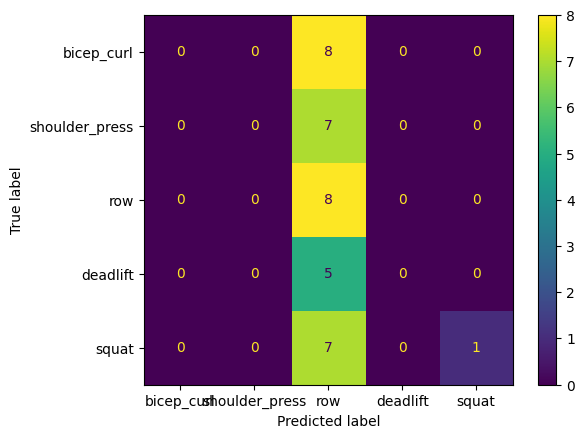

In [82]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()